In [0]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Dropout, MaxPooling2D ,Flatten, Conv2D, GlobalMaxPooling2D, Conv2DTranspose
from tensorflow.keras.models import Model  
from tensorflow.keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping
import keras
from itertools import groupby
import gc
from tensorflow.random import set_seed
from keras import regularizers

Using TensorFlow backend.


In [0]:
print("Tensorflow version ",tf.__version__)

Tensorflow version  2.2.0-rc4


In [0]:
# dowload the dataset
fashion_mnist = keras.datasets.fashion_mnist
(train_x, train_y), (test_x, test_y) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

4423680/4422102 [==============================] - 1s 0us/step


Labels distribution
0 : 6000, 1 : 6000, 2 : 6000, 3 : 6000, 4 : 6000, 5 : 6000, 6 : 6000, 7 : 6000, 8 : 6000, 9 : 6000, 


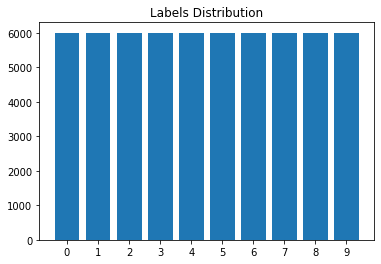

In [0]:
labels_no = np.unique(train_y)
x = [len(list(g)) for k,g in groupby(np.sort(train_y))]
print('Labels distribution')
for i in range(len(x)):
  print(labels_no[i],':',x[i],end =', ')
print()

plt.bar(labels_no,x)
plt.title('Labels Distribution')
plt.xticks(labels_no,labels_no)
plt.show()

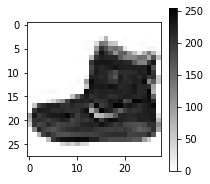

In [0]:
plt.figure(figsize=(3,3))
plt.imshow(train_x[0], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

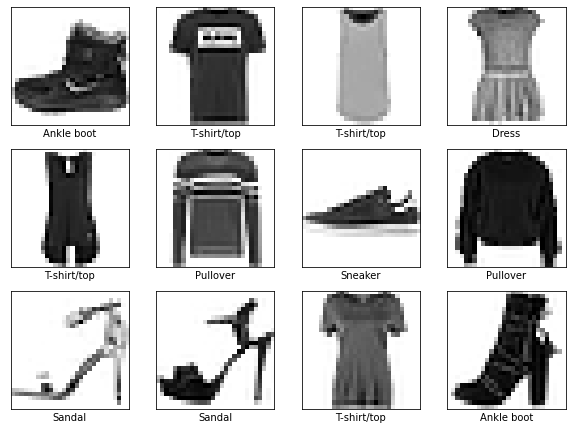

In [0]:
plt.figure(figsize=(10,10))
for i in range(12):
  plt.subplot(4,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_x[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[train_y[i]])
plt.show()

In [0]:
# Normalize to scale to [0,1]. Original scale [0,255]
train_x = train_x.astype('float32')
test_x = test_x.astype('float32')
train_x = train_x/255
test_x = test_x/255

In [0]:
# transform labels to categorical to use categorical cross entropy loss function
train_y = to_categorical(train_y, num_classes=None)
test_y = to_categorical(test_y, num_classes=None)

In [0]:
# create a validation set in proportion 90-10 of training set, using stratify to keep the balancedness of the dataset
train_x,val_x,train_y,val_y = train_test_split(train_x,train_y,test_size=0.1,stratify=train_y,random_state=4)

In [0]:
# function to plot loss and accuracy graph during training
def plot_history(h):
  fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,8))
  for label in h:
    ax1.plot(h[label].history['loss'], label='{0:s} train loss'.format(label))
    ax1.plot(h[label].history['val_loss'], label='{0:s} validation loss'.format(label))
  ax1.set_title('Model loss')
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epochs')
  ax1.legend(loc='best')
  for label in h:
    ax2.plot(h[label].history['accuracy'],label='{0:s} train accuracy'.format(label))  
    ax2.plot(h[label].history['val_accuracy'],label='{0:s} validation accuracy'.format(label))
  ax2.set_title('Model accuracy')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.legend(loc='lower right')
  plt.show()

In [0]:
# function to train every model
def train_model(model, train_data, train_labels, validation_data, epochs=6000, batch_size=1024,patience=4):
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=patience, restore_best_weights=True)
    hs = model.fit(x=train_data, y=train_labels,callbacks=[early_stop], validation_data=validation_data, epochs=epochs, verbose=1, batch_size=batch_size)
    print('Finished training.')
    print('------------------')
    return hs
# function to predict f1 score in train, validation and test set of every model
def predict(model,train_x,val_x,test_x,train_y,val_y,test_y):
  predict_train = model.predict(train_x)
  predict_val = model.predict(val_x)
  predict_test = model.predict(test_x)
  predict_train = to_categorical(np.argmax(predict_train,axis=1),10)
  predict_val = to_categorical(np.argmax(predict_val,axis=1),10)
  predict_test = to_categorical(np.argmax(predict_test,axis=1),10)
  f1_train = f1_score(train_y,predict_train,average='micro')
  f1_val = f1_score(val_y,predict_val,average='micro')
  f1_test = f1_score(test_y,predict_test,average='micro')
  return f1_train,f1_val,f1_test

def clean_up(model):
    K.clear_session()
    del model
    gc.collect() 

In [0]:
np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
set_seed(1981) # Define the seed for Tensorflow to have reproducible experiments.
categorizes = len(class_names)
img_size = train_x[0].shape

# Define the input layer.
input = Input(shape=img_size, name='Input')
x = input
# Define the remaining hidden layers.
x = Flatten()(x)
x = Dense(units=28**2/2, kernel_initializer='glorot_uniform', activation='relu', name='Hidden-{0:d}'.format(1))(x)
x = Dropout(0.3)(x)
# Define the output layer.
output = Dense(units=categorizes, kernel_initializer='glorot_uniform', activation='softmax', name='Output')(x)
# Define the model and train it.
mlp_model = Model(inputs=input, outputs=output)
mlp_model.compile(optimizer=Adam(lr=0.0006,), loss='categorical_crossentropy',metrics=['accuracy'])

mlp_model.summary()
mlp_history = train_model(model=mlp_model,
                          train_data=train_x,
                          train_labels=train_y,
                          validation_data=(val_x,val_y),
                          patience=6,
                          batch_size=int(len(train_x)/40),
                          epochs=1000
                         )

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
Hidden-1 (Dense)             (None, 392)               307720    
_________________________________________________________________
dropout (Dropout)            (None, 392)               0         
_________________________________________________________________
Output (Dense)               (None, 10)                3930      
Total params: 311,650
Trainable params: 311,650
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.9729 - accuracy: 0.6701 - val_loss: 0.5979 - 

In [0]:
f1_train,f1_val, f1_test = predict(mlp_model,train_x,val_x,test_x,train_y,val_y,test_y)
print("Train f1 micro :{0:.3f}".format(f1_train))
print("Val f1 micro :{0:.3f}".format(f1_val))
print("Test f1 micro :{0:.3f}".format(f1_test))

Train f1 micro :0.947
Val f1 micro :0.903
Test f1 micro :0.896


In [0]:
np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
set_seed(1981) # Define the seed for Tensorflow to have reproducible experiments.

# Define the input layer.
input = Input(shape=(28,28,), name='Input')
x = input
# Define the remaining hidden layers.
x = Flatten()(x)
x = Dense(units=28**2, kernel_initializer='glorot_uniform', activation='relu',kernel_regularizer=keras.regularizers.l2(0.002), name='Hidden-{0:d}'.format(1))(x)
x = Dense(units=28**2, kernel_initializer='glorot_uniform', activation='relu',kernel_regularizer=keras.regularizers.l2(0.002), name='Hidden-{0:d}'.format(2))(x)
# Define the output layer.
output = Dense(units=categorizes, kernel_initializer='glorot_uniform', activation='softmax', name='Output')(x)
# Define the model and train it.
mlp_model_2 = Model(inputs=input, outputs=output)
mlp_model_2.compile(optimizer=Adam(lr=0.0005,), loss='categorical_crossentropy',metrics=['accuracy'])
mlp_model_2.summary()
mlp_history_2 = train_model(model=mlp_model_2,
                          train_data=train_x,
                          train_labels=train_y,
                          validation_data=(val_x,val_y),
                          patience=6,
                          batch_size=int(len(train_x)/40),
                          epochs=1000
                         )

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 28, 28)]          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
Hidden-1 (Dense)             (None, 784)               615440    
_________________________________________________________________
Hidden-2 (Dense)             (None, 784)               615440    
_________________________________________________________________
Output (Dense)               (None, 10)                7850      
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
40/40 [==============================] - 0s 11ms/step - loss: 3.4015 - accuracy: 0.7516 - val_loss: 2.

Train f1 micro :0.921
Val f1 micro :0.899
Test f1 micro :0.888


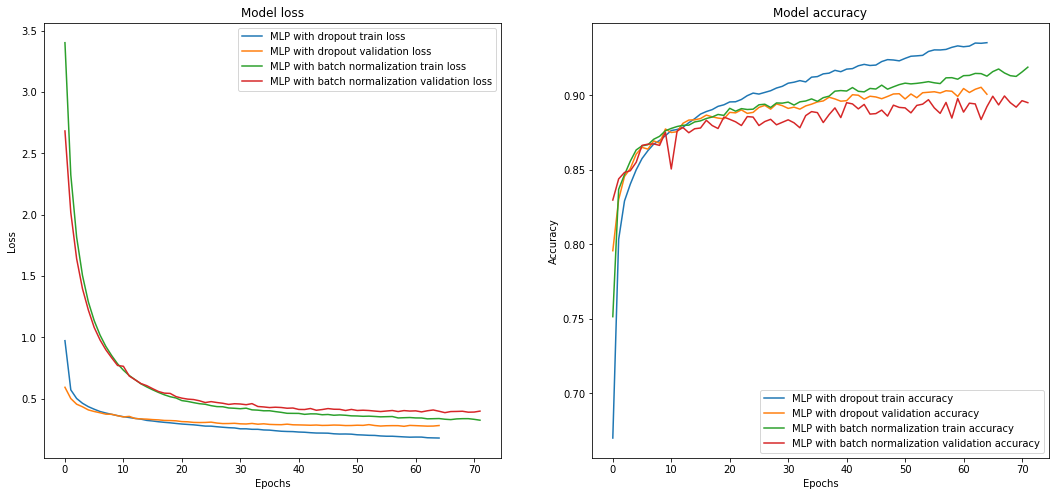

In [0]:
f1_train,f1_val,f1_test = predict(mlp_model_2,train_x,val_x,test_x,train_y,val_y,test_y)
print("Train f1 micro :{0:.3f}".format(f1_train))
print("Val f1 micro :{0:.3f}".format(f1_val))
print("Test f1 micro :{0:.3f}".format(f1_test))
plot_history({'MLP with dropout':mlp_history,'MLP with batch normalization':mlp_history_2})

In [0]:
np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
set_seed(1981) # Define the seed for Tensorflow to have reproducible experiments.
categorizes = len(class_names)

# Define the input layer.
input = Input(shape=(28,28,), name='Input')
x = input
# Define the remaining hidden layers.
x = Flatten()(x)
x = Dense(units=28**2, kernel_initializer='glorot_uniform', activation='relu', name='Hidden-{0:d}'.format(1))(x)
x = Dropout(0.3)(x)  
# Define the output layer.
output = Dense(units=categorizes, kernel_initializer='glorot_uniform', activation='softmax', name='Output')(x)
# Define the model and train it.
mlp_model_sgd = Model(inputs=input, outputs=output)
mlp_model_sgd.compile(optimizer=SGD(lr=0.01,momentum=0.75,nesterov=True), loss='categorical_crossentropy',metrics=['accuracy'])
mlp_model_sgd.summary()
mlp_history_sgd= train_model(model=mlp_model_sgd,
                          train_data=train_x,
                          train_labels=train_y,
                          validation_data=(val_x,val_y),
                          patience=6,
                          batch_size=int(len(train_x)/40),
                          epochs=1000
                         )

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 28, 28)]          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
Hidden-1 (Dense)             (None, 784)               615440    
_________________________________________________________________
dropout_1 (Dropout)          (None, 784)               0         
_________________________________________________________________
Output (Dense)               (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
40/40 [==============================] - 0s 9ms/step - loss: 1.4441 - accuracy: 0.5406 - val_loss: 0.9787 

Train f1 micro :0.931
Val f1 micro :0.898
Test f1 micro :0.888


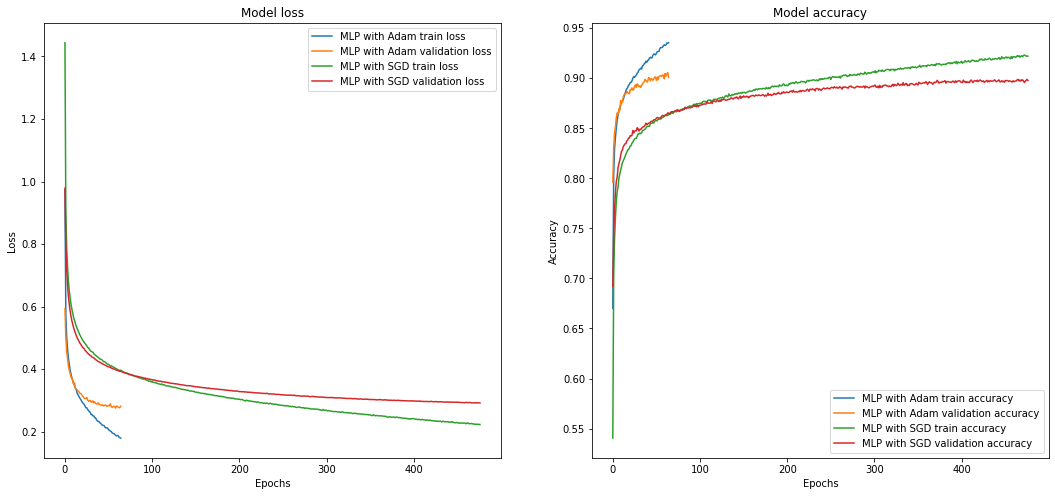

In [0]:
f1_train,f1_val,f1_test = predict(mlp_model_sgd,train_x,val_x,test_x,train_y,val_y,test_y)
print("Train f1 micro :{0:.3f}".format(f1_train))
print("Val f1 micro :{0:.3f}".format(f1_val))
print("Test f1 micro :{0:.3f}".format(f1_test))
plot_history({'MLP with Adam':mlp_history,'MLP with SGD':mlp_history_sgd})

In [0]:
categorizes = len(class_names)
np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
set_seed(1981) # Define the seed for Tensorflow to have reproducible experiments.
Filter=32
# Define the input layer.
input = Input(shape=(28,28,1), name='Input')
# Define the remaining hidden layers.
x = Conv2D(filters=Filter , kernel_size=5, kernel_initializer='glorot_uniform',kernel_regularizer=keras.regularizers.l2(0.0009),padding='valid',activation='relu')(input)
x = Conv2D(filters=Filter ,kernel_size=5,kernel_initializer='glorot_uniform',kernel_regularizer=keras.regularizers.l2(0.0009),padding='valid',activation='relu')(x)
max_pool = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=Filter*2 ,kernel_size=5,kernel_initializer='glorot_uniform',kernel_regularizer=keras.regularizers.l2(0.0009),padding='valid',activation='relu')(max_pool)
flat = Flatten()(x)
x = Dense(units=2304, kernel_initializer='glorot_uniform', activation='relu',kernel_regularizer=keras.regularizers.l2(0.0009), name='Hidden-{0:d}'.format( 1))(flat)
# define the output layer
output = Dense(units=categorizes, kernel_initializer='glorot_uniform', activation='softmax', name='Output')(x)
cnn_model = Model(inputs=input, outputs=output)
cnn_model.compile(optimizer=Adam(learning_rate=0.0003), loss='categorical_crossentropy',metrics=['accuracy'])
cnn_model.summary()
cnn_history = train_model(model=cnn_model,
                          train_data=train_x.reshape((train_x.shape[0],28,28,1)),
                          train_labels=train_y,
                          validation_data=(val_x.reshape((val_x.shape[0],28,28,1)),val_y),
                          patience=6,
                          batch_size=int(len(train_x)/40),
                          epochs=1000
                         )

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 64)          51264     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
Hidden-1 (Dense)             (None, 2304)              5310

Train f1 micro :0.954
Val f1 micro :0.919
Test f1 micro :0.913


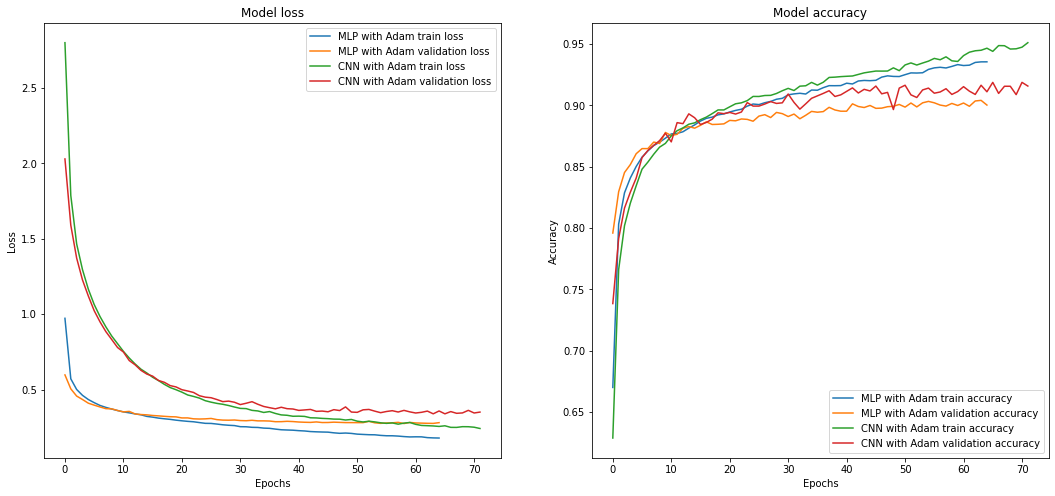

In [0]:
f1_train,f1_val,f1_test = predict(cnn_model,train_x,val_x,test_x,train_y,val_y,test_y)
print("Train f1 micro :{0:.3f}".format(f1_train))
print("Val f1 micro :{0:.3f}".format(f1_val))
print('Test f1 micro :{0:.3f}'.format(f1_test))
plot_history({'MLP with Adam':mlp_history,'CNN with Adam':cnn_history})

In [0]:
np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
set_seed(1981) # Define the seed for Tensorflow to have reproducible experiments. 
categorizes = len(class_names)
Filter=32
# Define the input layer
input = Input(shape=(28,28,1), name='Input')
# Define the hidden layers
x = Conv2D(filters=Filter , kernel_size=(5,5), kernel_initializer='glorot_uniform',padding='valid',activation='relu')(input)
x = Conv2D(filters=Filter ,kernel_size=(5,5),kernel_initializer='glorot_uniform',padding='valid',activation='relu')(x)
max_pool = MaxPooling2D(pool_size=(1,1))(x)
x = Conv2D(filters=Filter*2 ,kernel_size=(3,3),kernel_initializer='glorot_uniform',padding='valid',activation='relu')(max_pool)
x = MaxPooling2D()(x)
x = Conv2D(filters=Filter*2 ,kernel_size=(3,3),kernel_initializer='glorot_uniform',padding='valid',activation='relu')(x)
max_pool = GlobalMaxPooling2D()(x)
x = Dropout(rate=0.1)(max_pool)
# Define the output layer
output = Dense(units=categorizes, kernel_initializer='glorot_uniform', activation='softmax', name='Output')(x)
cnn_model2 = Model(inputs=input, outputs=output)
cnn_model2.compile(optimizer=Adam(lr=0.0007), loss='categorical_crossentropy',metrics=['accuracy'])
cnn_model2.summary()
cnn_history2 = train_model(model=cnn_model2,
                          train_data=train_x.reshape((train_x.shape[0],28,28,1)),
                          train_labels=train_y,
                          validation_data=(val_x.reshape((val_x.shape[0],28,28,1)),val_y),
                          patience=6,
                          batch_size=int(len(train_x)/40),
                          epochs=1000
                         )

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 20, 20, 32)        25632     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 18, 18, 64)        18496     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 7, 7, 64)          369

Train f1 micro :0.917
Val f1 micro :0.905
Test f1 micro :0.891


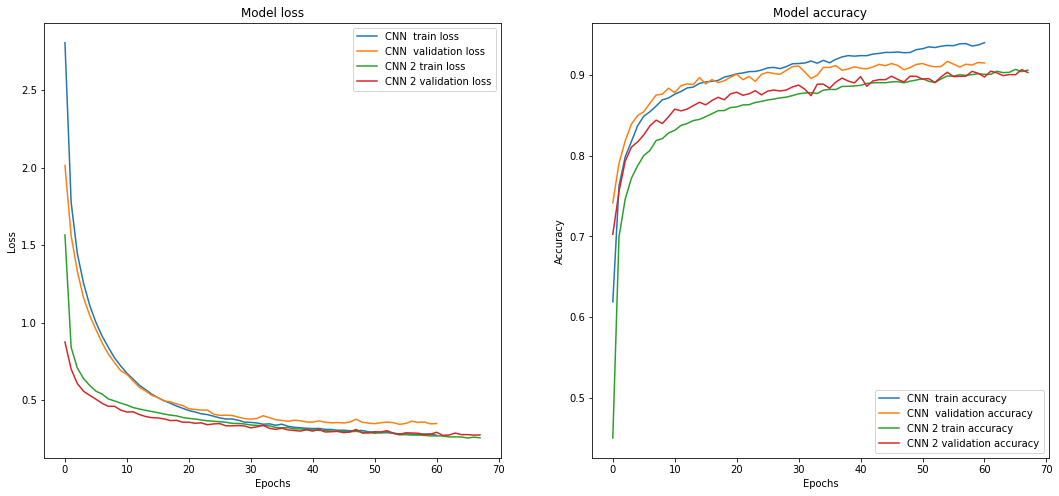

In [0]:
f1_train,f1_val,f1_test = predict(cnn_model2,train_x,val_x,test_x,train_y,val_y,test_y)
print("Train f1 micro :{0:.3f}".format(f1_train))
print("Val f1 micro :{0:.3f}".format(f1_val))
print('Test f1 micro :{0:.3f}'.format(f1_test))
plot_history({'CNN ':cnn_history,'CNN 2':cnn_history2})